In [ ]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer  
from textstat import textstat
import language_tool_python
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

##### Load text utils

In [ ]:
nltk_data_path = '/Users/vadymvilhurin/Documents/KPI/NLP'
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_path)

nltk.download('words', download_dir=nltk_data_path, quiet=True)
from nltk.corpus import words


language_tool = language_tool_python.LanguageTool('en-US')

In [ ]:
class StudentEssayClassifier:
    def __init__(self):
        self.stemmer = PorterStemmer() 
        self.stop_words = set(stopwords.words('english'))
        self.classifier = None
        self.english_words = set(words.words())

        
    def load_data_from_directory(self, directory_path):
        data = []
        files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]
        
        for filename in tqdm(files, desc="Loading files"):
            file_path = os.path.join(directory_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    data.append({
                        'file_name': filename,
                        'essay_text': content
                    })
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
        
        return pd.DataFrame(data)
    
    def preprocess_text(self, text):
        text = text.lower()
        
        text = re.sub(r'[^\w\s]', '', text)
        
        tokens = word_tokenize(text)
        
        tokens = [self.stemmer.stem(token) for token in tokens if token not in self.stop_words]
        
        return ' '.join(tokens)
    
    def extract_features(self, text):
        features = {}
        
        original_text = text
        preprocessed_text = self.preprocess_text(text)
        
        features['word_count'] = len(word_tokenize(original_text))
        features['sentence_count'] = len(sent_tokenize(original_text))
        
        if features['sentence_count'] > 0:
            features['avg_words_per_sentence'] = features['word_count'] / features['sentence_count']
        else:
            features['avg_words_per_sentence'] = 0
            
        word_lengths = [len(word) for word in word_tokenize(original_text) if word.isalpha()]
        if word_lengths:
            features['avg_word_length'] = sum(word_lengths) / len(word_lengths)
            features['max_word_length'] = max(word_lengths)
        else:
            features['avg_word_length'] = 0
            features['max_word_length'] = 0
            
        # Vocabulary richness
        unique_words = set(word_tokenize(preprocessed_text))
        if features['word_count'] > 0:
            features['lexical_diversity'] = len(unique_words) / features['word_count']
        else:
            features['lexical_diversity'] = 0
            
        # Readability metrics
        try:
            features['flesch_reading_ease'] = textstat.flesch_reading_ease(original_text)
            features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(original_text)
            features['coleman_liau_index'] = textstat.coleman_liau_index(original_text)
            features['automated_readability_index'] = textstat.automated_readability_index(original_text)
        except Exception as e:
            print(f"Warning: Readability metrics issue: {e}")
            features['flesch_reading_ease'] = 0
            features['flesch_kincaid_grade'] = 0
            features['coleman_liau_index'] = 0
            features['automated_readability_index'] = 0
        
        # Grammar and spelling errors
        language_tool_matches = language_tool.check(original_text)
        features['grammar_error_count'] = len(language_tool_matches)
        if features['word_count'] > 0:
            features['grammar_error_ratio'] = features['grammar_error_count'] / features['word_count']
        else:
            features['grammar_error_ratio'] = 0
            
        # Part of speech tagging with error handling
        
        doc = nlp(original_text)
        pos_counts = Counter([token.pos_ for token in doc])
        
        # Common POS tags to include
        common_pos = ['NOUN', 'VERB', 'ADJ', 'ADV', 'DET', 'PRON', 'ADP', 'CONJ', 'CCONJ']
        for pos in common_pos:
            features[f'pos_{pos}_count'] = pos_counts.get(pos, 0)
            if features['word_count'] > 0:
                features[f'pos_{pos}_ratio'] = pos_counts.get(pos, 0) / features['word_count']
            else:
                features[f'pos_{pos}_ratio'] = 0
                
        # Syntactic complexity
        # Count of different dependency relations
        dep_counts = Counter([token.dep_ for token in doc])
        features['unique_dep_relations'] = len(dep_counts)
        
        # Advanced syntactic features
        features['conjunction_count'] = len([token for token in doc if token.pos_ in ['CCONJ', 'SCONJ']])
        
        # Sentence complexity
        sentences = list(doc.sents)
        if sentences:
            features['avg_sentence_length_chars'] = sum(len(sent.text) for sent in sentences) / len(sentences)
            
            # Depth of syntactic tree
            features['avg_dependency_tree_depth'] = sum(self._get_max_depth(sent.root) for sent in sentences) / len(sentences)
        else:
            features['avg_sentence_length_chars'] = 0
            features['avg_dependency_tree_depth'] = 0

        # Count words not in dictionary (potential spelling errors)
        word_tokens = [word.lower() for word in word_tokenize(original_text) if word.isalpha()]
        misspelled = [word for word in word_tokens if word not in self.english_words]
        features['spelling_error_count'] = len(misspelled)
        
        if features['word_count'] > 0:
            features['spelling_error_ratio'] = features['spelling_error_count'] / features['word_count']
        else:
            features['spelling_error_ratio'] = 0
        
        return features
    
    def _get_max_depth(self, token, current_depth=0):
        if not list(token.children):
            return current_depth
        return max(self._get_max_depth(child, current_depth + 1) for child in token.children)
    
    def extract_all_features(self, df):
        all_features = []
        
        for i, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
            text = row['essay_text']
            try:
                features = self.extract_features(text)
                features['file_name'] = row['file_name']
                all_features.append(features)
            except Exception as e:
                print(f"Error processing file {row['file_name']}: {e}")
                minimal_features = {
                    'file_name': row['file_name'],
                    'word_count': len(word_tokenize(text)),
                    'sentence_count': len(sent_tokenize(text))
                }
                all_features.append(minimal_features)
            
        return pd.DataFrame(all_features)
    
    
    def unsupervised_clustering(self, X, n_clusters=6):
        

        if 'file_name' in X.columns:
            file_names = X['file_name']
            X = X.drop('file_name', axis=1)
        else:
            file_names = None
        

        with tqdm(total=1, desc="Feature scaling") as pbar:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            pbar.update(1)
        
        with tqdm(total=1, desc="KMeans clustering") as pbar:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_scaled)
            pbar.update(1)
        
        
        with tqdm(total=1, desc="PCA computation") as pbar:
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_scaled)
            pbar.update(1)
        
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')
        
        plt.title('Essay Clusters')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()
        
        kmeans_centers = kmeans.cluster_centers_
        
        feature_importance = np.std(kmeans_centers, axis=0)
        
        plt.figure(figsize=(12, 8))
        sorted_idx = feature_importance.argsort()[::-1]
        plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx])
        plt.xticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx], rotation=90)
        plt.title('Feature Importance for Clusters')
        plt.tight_layout()
        plt.show()
        
        result_df = pd.DataFrame({
            'predicted_grade_cluster': cluster_labels
        })
        
        if file_names is not None:
            result_df['file_name'] = file_names
        
        return cluster_labels, result_df

def main(n_cluster):
    classifier = StudentEssayClassifier()
    df = classifier.load_data_from_directory('/Users/vadymvilhurin/Documents/KPI/NLP/feedback-prize-2021/train')
    
    # features_df = classifier.extract_all_features(df)
    # with tqdm(total=1, desc="Saving features") as pbar:
    #     features_df.to_csv('essay_features.csv', index=False)
    #     pbar.update(1)

    features_df = pd.read_csv("/Users/vadymvilhurin/Documents/KPI/NLP/essay_features.csv")
    cluster_labels, results_df = classifier.unsupervised_clustering(features_df, n_clusters = n_cluster)
    
    with tqdm(total=1, desc="Merging results") as pbar:
        results_df = pd.merge(results_df, df, on='file_name')
        pbar.update(1)
    
    with tqdm(total=1, desc="Saving results") as pbar:
        results_df.to_csv('essays_with_predictions.csv', index=False)
        pbar.update(1)
    

    for cluster_id in tqdm(range(max(cluster_labels) + 1), desc="Analyzing clusters"):
        cluster_essays = results_df[results_df['predicted_grade_cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} contains {len(cluster_essays)} essays.")




PCA computation: 100%|██████████| 1/1 [00:00<00:00, 78.66it/s]


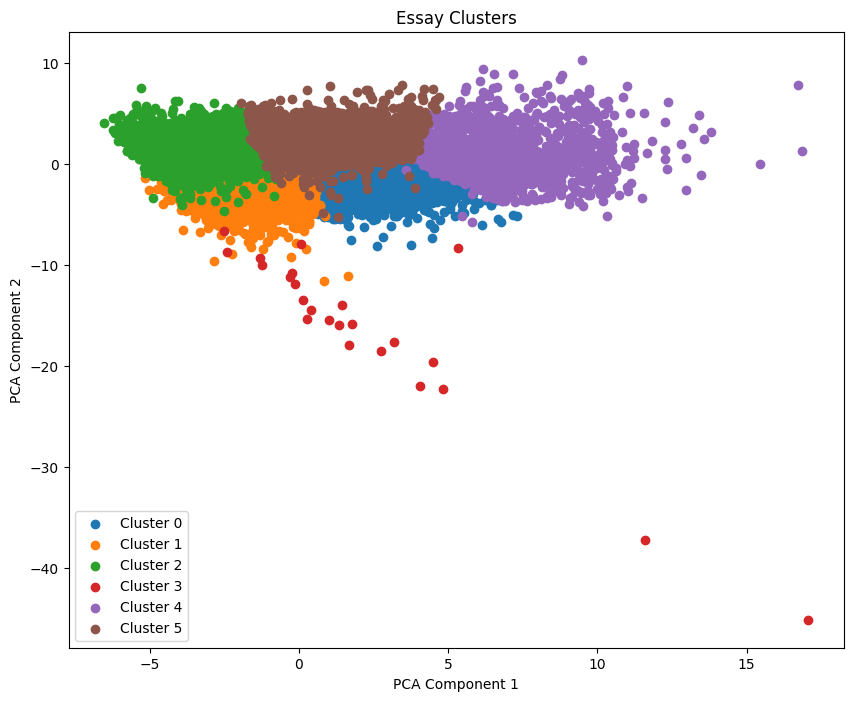

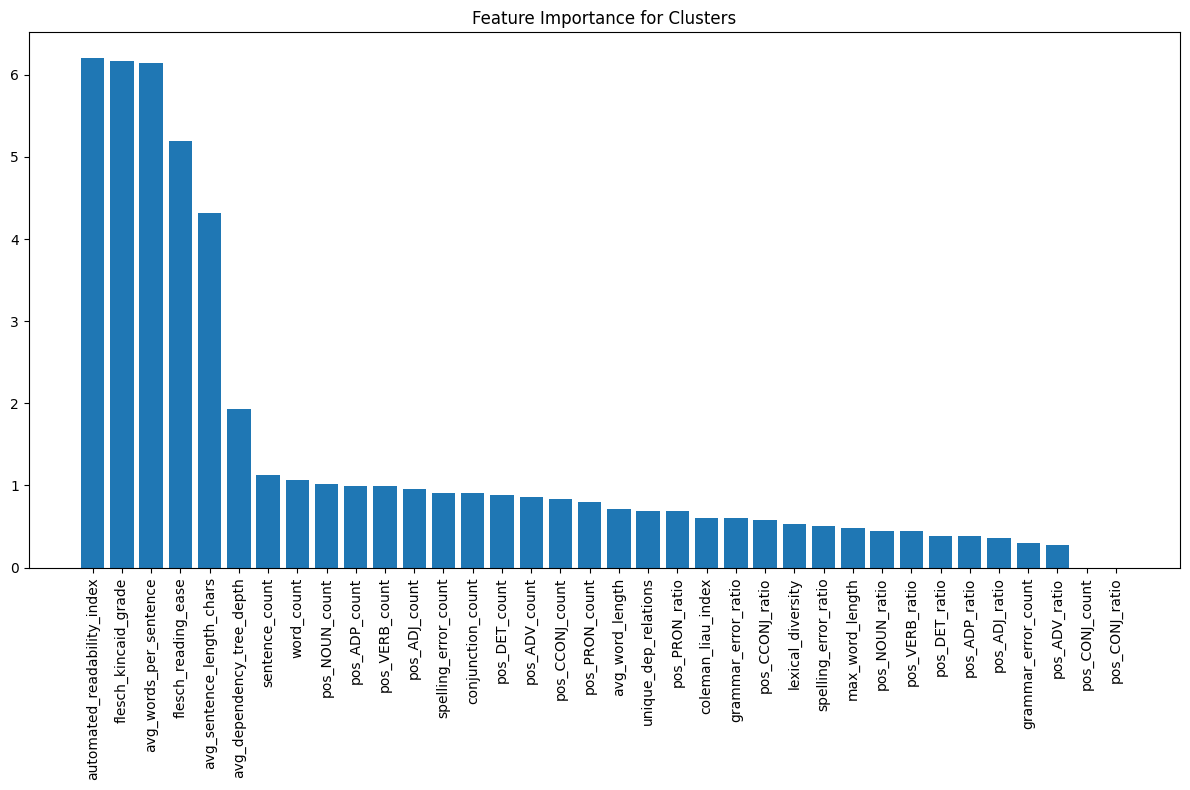

Analyzing clusters: 100%|██████████| 6/6 [00:00<00:00, 1721.56it/s]


Cluster 0 contains 3073 essays.

Cluster 1 contains 3925 essays.

Cluster 2 contains 3915 essays.

Cluster 3 contains 24 essays.

Cluster 4 contains 1437 essays.

Cluster 5 contains 3220 essays.


In [3]:
main(n_cluster=6)